# Brownian Motion

Two tasks: 
* What's the volatility of each node? (graph independent)
* What's the natural frequency of each node? (graph dependent)

Create simulation

In [25]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
from pygsig.graph import StaticGraphTemporalSignal
import torch_geometric.transforms as T
from pygsig.signature import SignatureFeatures, StatFeatures

# Simulation parameters

def run_simultion(num_nodes = 200,
                  p_across_blocks = 0.01,
                  p_within_blocks = 0.1,                  
                  dim = 2,
                  time_horizon = 10,
                  dt = 1e-3,
                  beta_gain = 5,
                  sigma_gain = 1,
                  simulation_seed=1,
                  target_seed=29,
                  graph_seed=29):
    
    num_time_steps = int(time_horizon / dt)

    def kuramoto(graph, theta, omega, dt):
        deg = dict(graph.degree())
        dtheta = np.zeros_like(theta)
        for u, v, data in graph.edges(data=True):
            coupling = data['weight']
            dtheta[u] += dt * (omega[u]  + (1/deg[u]) * coupling * np.sin(theta[v] - theta[u]))
            dtheta[v] += dt * (omega[v]  + (1/deg[v]) * coupling * np.sin(theta[u] - theta[v]))
        return theta + dtheta

    def periodic_drift(beta, theta, omega,mu_0, t):
        return mu_0 + beta*np.sin(omega*t + theta)

    # Create a graph

    block_sizes = [num_nodes//3,num_nodes//3,num_nodes//3]
    block_probs = [[p_within_blocks, p_across_blocks, p_across_blocks],
                   [p_across_blocks, p_within_blocks, p_across_blocks],
                   [p_across_blocks, p_across_blocks, p_within_blocks]]
    graph = nx.stochastic_block_model(block_sizes, block_probs, seed=graph_seed)

    for edge in graph.edges:
        graph[edge[0]][edge[1]]['weight'] = 1
    
    for node in graph.nodes:
        if graph.nodes[node]['block'] == 0:
            graph.nodes[node]['omega'] = 0.25 + np.random.randn() * 0.0
        if graph.nodes[node]['block'] == 1:
            graph.nodes[node]['omega'] = 0.50 + np.random.randn() * 0.0
        if graph.nodes[node]['block'] == 2:
            graph.nodes[node]['omega'] = 0.75 + np.random.randn() * 0.0
    # Nature frequency (target variable)
    np.random.seed(target_seed)
    
    # Othe oscilator perameters
    np.random.seed(simulation_seed)
    omega = np.stack([np.ones(dim) * graph.nodes[node]['omega'] for node in graph.nodes])
    theta = 2 * np.pi * np.random.rand(num_nodes,dim)  # Initial phases
    beta =  beta_gain * np.ones((num_nodes,dim)) # amplitude
    mu_initial = np.random.rand(num_nodes,dim) # initial drift

    # brownian motion parameters
    X = np.random.rand(num_nodes,dim) # signal
    drift = np.random.rand(num_nodes,dim) # drift
    sigma = sigma_gain * np.eye(dim) # diffusion matrix

    # Simulate
    theta_traj = np.zeros((num_nodes,num_time_steps,dim))
    mu_traj = np.zeros((num_nodes,num_time_steps,dim))
    paths = np.zeros((num_nodes,num_time_steps, dim))

    # Time sequence
    tt = np.linspace(0, time_horizon, num_time_steps)

    for step,t in enumerate(tt):
        theta_traj[:, step] = theta
        mu_traj[:,step] = drift
        paths[:,step,:] = X
        theta = kuramoto(graph, theta, omega,dt)
        drift = periodic_drift(beta, theta,omega, mu_initial, t)
        X = X + dt * drift + np.sqrt(dt) * np.random.randn(num_nodes,dim) @ sigma

    return paths, omega , graph

def get_sequence(paths,graph):
    snapshot_count = paths.shape[1]
    df_edge = nx.to_pandas_edgelist(graph.to_directed())
    edge_index = torch.tensor(df_edge[['source','target']].values.T,dtype=torch.long)
    edge_weight = torch.tensor(df_edge['weight'].values,dtype=torch.float)
    snapshot_count = paths.shape[1]
    features = [ paths[:,t,:] for t in range(snapshot_count)]
    targets = [ torch.tensor(np.array([graph.nodes[node]['omega'] for node in graph.nodes]),dtype=torch.float).unsqueeze(-1) for _ in range(snapshot_count)]
    # Sequential Data
    return StaticGraphTemporalSignal(edge_index=edge_index,edge_weight=edge_weight,features=features,targets=targets)


Make dataset consisting of multiple SDE trajectories

In [2]:
from tqdm import tqdm

num_runs = 20
num_nodes = 300
seq_dataset = []

betas = np.random.choice([0.1,0.5,1,2,5],num_runs)
sigmas = np.random.choice([0.1,0.5,1,2,5],num_runs)

with tqdm(total=num_runs) as pbar:
    for run in range(num_runs):
        paths, omega, graph = run_simultion(num_nodes = num_nodes,
                                            p_across_blocks = 0.05,
                                            p_within_blocks = 0.1,
                                            dim = 2,
                                            time_horizon = 2,
                                            dt = 1e-3,
                                            beta_gain=betas[run],
                                            sigma_gain=sigmas[run],
                                            simulation_seed=29+run,
                                            target_seed=29+run,
                                            graph_seed=29)
        
        seq = get_sequence(paths,graph)
        seq_dataset.append(seq)
        pbar.update(1)

100%|██████████| 20/20 [09:16<00:00, 27.84s/it]


save dataset

In [3]:
import torch
torch.save(seq_dataset,'datasets/brownian/brownian-2d-3b.pt')

load dataset

In [26]:
import torch
seq_dataset = torch.load('datasets/brownian/brownian-2d-3b.pt')

/var/folders/0b/l3krx7155s56x0pllytjm6dc0000gn/T/ipykernel_59426/908550704.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')
/var/folders/0b/l3krx7155s56x0pllytjm6dc0000gn/T/ipykernel_59426/908550704.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


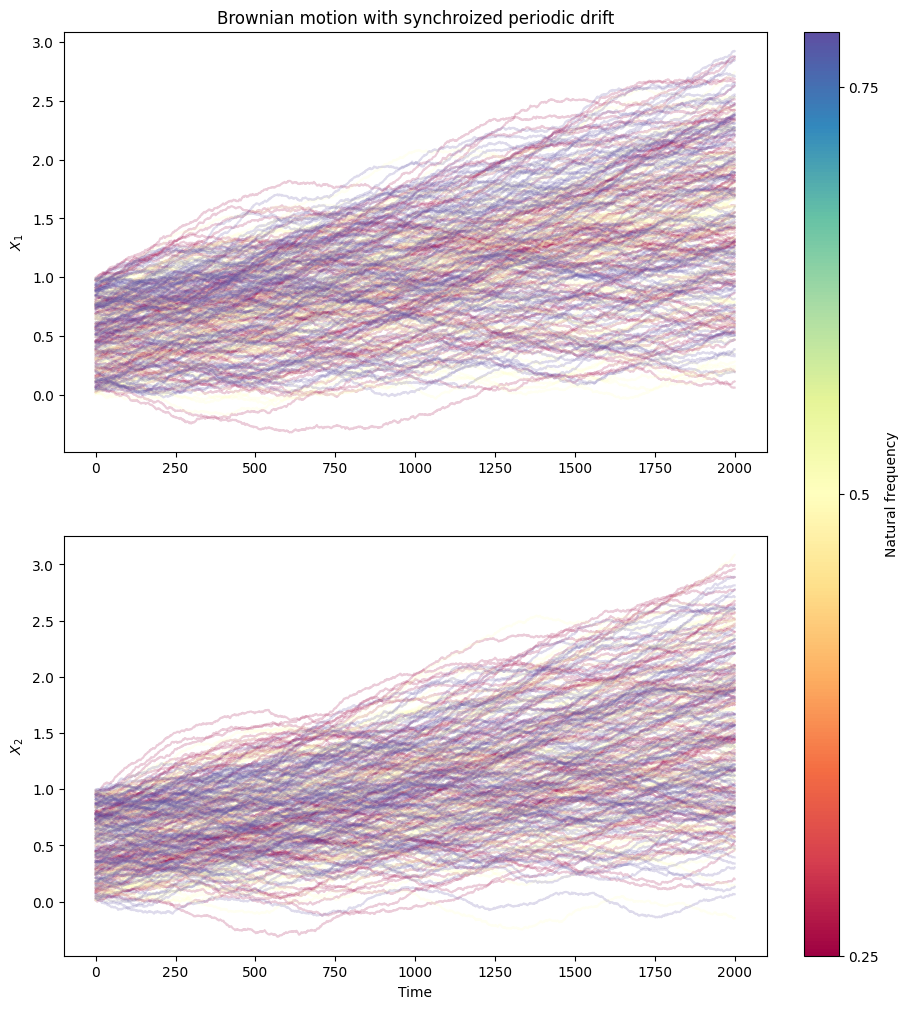

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Randomly select a run from the dataset
num_runs = len(seq_dataset)
run = np.random.choice(range(num_runs))
seq = seq_dataset[run]

# Get the number of nodes and snapshots in the sequence
num_nodes = seq.num_nodes
snapshot_count = seq.snapshot_count
tt = np.arange(snapshot_count)

# Convert targets to a numpy array and use Spectral colormap
targets = seq.y.numpy().squeeze()
cmap = cm.get_cmap('Spectral')
# Normalize the target values for the colormap
norm = mcolors.Normalize(vmin=targets.min(), vmax=targets.max())

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 0.05], height_ratios=[1, 1], wspace=0.1)

# First subplot for dimension 1
ax1 = fig.add_subplot(gs[0, 0])

# Plot the time series for each node in the first dimension
for node in range(num_nodes):
    time_series = np.array([seq.features[t][node] for t in range(snapshot_count)])
    ax1.plot(tt, time_series[:, 0], alpha=0.2, color=cmap(norm(targets[node])))

ax1.set_ylabel('$X_1$')
ax1.set_title('Brownian motion with synchroized periodic drift')

# Second subplot for dimension 2
ax2 = fig.add_subplot(gs[1, 0])

for node in range(num_nodes):
    time_series = np.array([seq.features[t][node] for t in range(snapshot_count)])
    ax2.plot(tt, time_series[:, 1], alpha=0.2, color=cmap(norm(targets[node])))

ax2.set_xlabel('Time')
ax2.set_ylabel('$X_2$')

# Colorbar next to the first subplot
cax = fig.add_subplot(gs[:, 1])

# Create ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to the right of the figure next to the plots
cbar = fig.colorbar(sm, cax=cax, label='Natural frequency')
cbar.set_ticks([0.25, 0.5, 0.72])
cbar.set_ticklabels([0.25, 0.5, 0.75])

# Adjust layout
plt.tight_layout()
plt.show()

Signature transform

In [31]:
from pygsig.signature import SignatureFeatures
from tqdm import tqdm

signature_depth = 5

dataset = []
for seq in tqdm(seq_dataset):
    signature_transform = SignatureFeatures(sig_depth=signature_depth, normalize=True, log_signature=True,lead_lag=True)
    dataset.append(signature_transform(seq))

100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


Train, baby, train!

Model: GCNRegression
Number of parameters: 18945
Signature depth: 5
Splits: 4, Trials: 1, Runs: 20, Epochs: 100


100%|██████████| 80/80 [00:26<00:00,  3.01it/s]

RMSE: 0.4009 ± 0.0215, MAE: 0.1323 ± 0.0160 


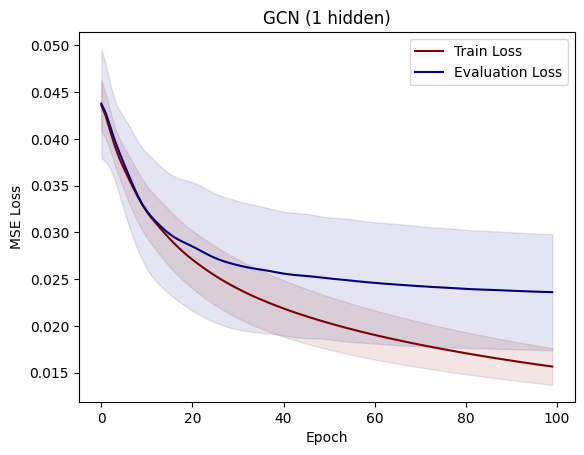

Model: GCNRegression
Number of parameters: 23105
Signature depth: 5
Splits: 4, Trials: 1, Runs: 20, Epochs: 100


100%|██████████| 80/80 [00:42<00:00,  1.89it/s]

RMSE: 0.3935 ± 0.0171, MAE: 0.1253 ± 0.0123 


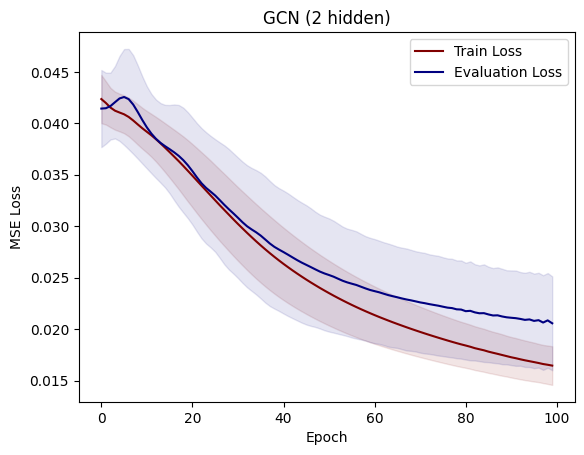

Model: GCNRegression
Number of parameters: 27265
Signature depth: 5
Splits: 4, Trials: 1, Runs: 20, Epochs: 100


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]

RMSE: 0.4180 ± 0.0229, MAE: 0.1485 ± 0.0214 


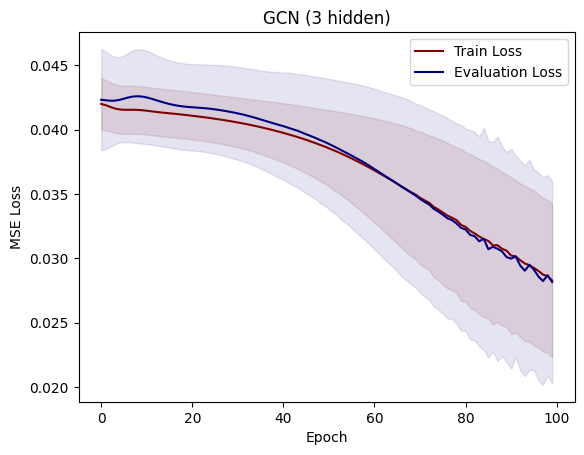

Model: MLPRegression
Number of parameters: 18945
Signature depth: 5
Splits: 4, Trials: 1, Runs: 20, Epochs: 100


100%|██████████| 80/80 [00:05<00:00, 15.76it/s]


RMSE: 0.4921 ± 0.0494, MAE: 0.2001 ± 0.0403 


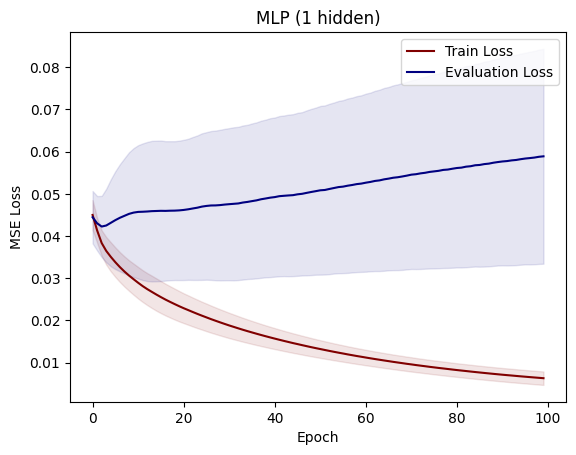

Model: MLPRegression
Number of parameters: 23105
Signature depth: 5
Splits: 4, Trials: 1, Runs: 20, Epochs: 100


100%|██████████| 80/80 [00:06<00:00, 12.92it/s]


RMSE: 0.5002 ± 0.0599, MAE: 0.2065 ± 0.0486 


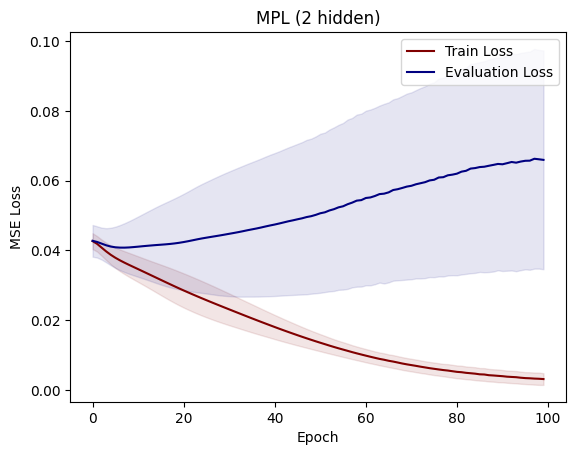

Model: MLPRegression
Number of parameters: 27265
Signature depth: 5
Splits: 4, Trials: 1, Runs: 20, Epochs: 100


100%|██████████| 80/80 [00:07<00:00, 11.04it/s]

RMSE: 0.4990 ± 0.0602, MAE: 0.2048 ± 0.0491 


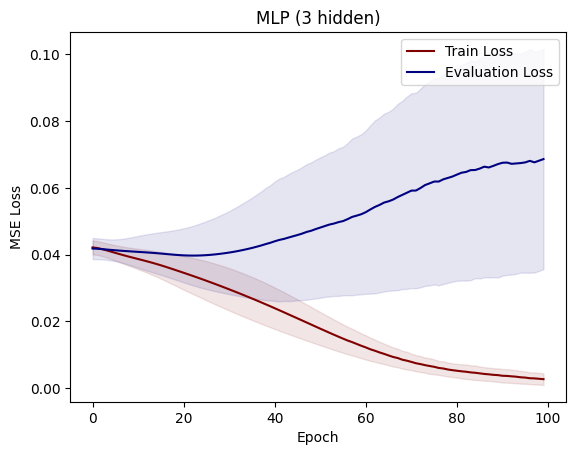

In [32]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNRegression, MLPRegression
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = dataset[0].num_nodes
dim = dataset[0].num_node_features
num_splits = 4 # split the data into 4 groups
num_runs = len(dataset)
num_trials = 1
num_epochs = 100

learning_rate = 1e-3
lasso = 1e-4
num_hidden = 64

print_during_training = False

# initialize models
models = []
models += [GCNRegression(num_channels=[dataset[0].num_node_features, num_hidden, 1])] # 1 hidden
models += [GCNRegression(num_channels=[dataset[0].num_node_features, num_hidden,num_hidden, 1])] # 2 hidden
models += [GCNRegression(num_channels=[dataset[0].num_node_features, num_hidden,num_hidden,num_hidden, 1])] # 3 hidden
models += [MLPRegression(num_channels=[dataset[0].num_node_features, num_hidden, 1])] #MLP with 1 hidden
models += [MLPRegression(num_channels=[dataset[0].num_node_features, num_hidden,num_hidden, 1])] #MLP with 2 hidden
models += [MLPRegression(num_channels=[dataset[0].num_node_features, num_hidden,num_hidden,num_hidden, 1])] #MLP with 3 hidden

model_names = ['GCN (1 hidden)','GCN (2 hidden)','GCN (3 hidden)','MLP (1 hidden)','MPL (2 hidden)','MLP (3 hidden)']

rmse_models = []
mae_models = []

for model_number,model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Signature depth: {signature_depth}")
    print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
    criterion = nn.MSELoss() # loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) # optimizer
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) # array storing the train loss for each split, run, trial, epoch
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    rmse = np.zeros([num_splits, num_runs, num_trials])
    mae = np.zeros([num_splits, num_runs, num_trials])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,seed=29)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        rmse[split, run, trial] = np.sqrt(mean_squared_error(data.y[test_mask], out[test_mask]))
                        mae[split, run, trial] = mean_absolute_error(data.y[test_mask], out[test_mask])

    print(f'RMSE: {np.mean(rmse):.4f} ± {np.std(np.sqrt(rmse)):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f} ')  
    rmse_models.append(rmse)
    mae_models.append(mae)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2))
    avg_eval_losses = np.mean(eval_losses, axis=(0,1,2))
    std_train_losses = np.std(train_losses, axis=(0,1,2))
    std_eval_losses = np.std(eval_losses, axis=(0,1,2))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses,  label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1,color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()

/var/folders/0b/l3krx7155s56x0pllytjm6dc0000gn/T/ipykernel_59426/2795294919.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)  # Set the font size for the x-axis labels and rotate them
/var/folders/0b/l3krx7155s56x0pllytjm6dc0000gn/T/ipykernel_59426/2795294919.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis2.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)  # Set the font size for the x-axis labels and rotate them


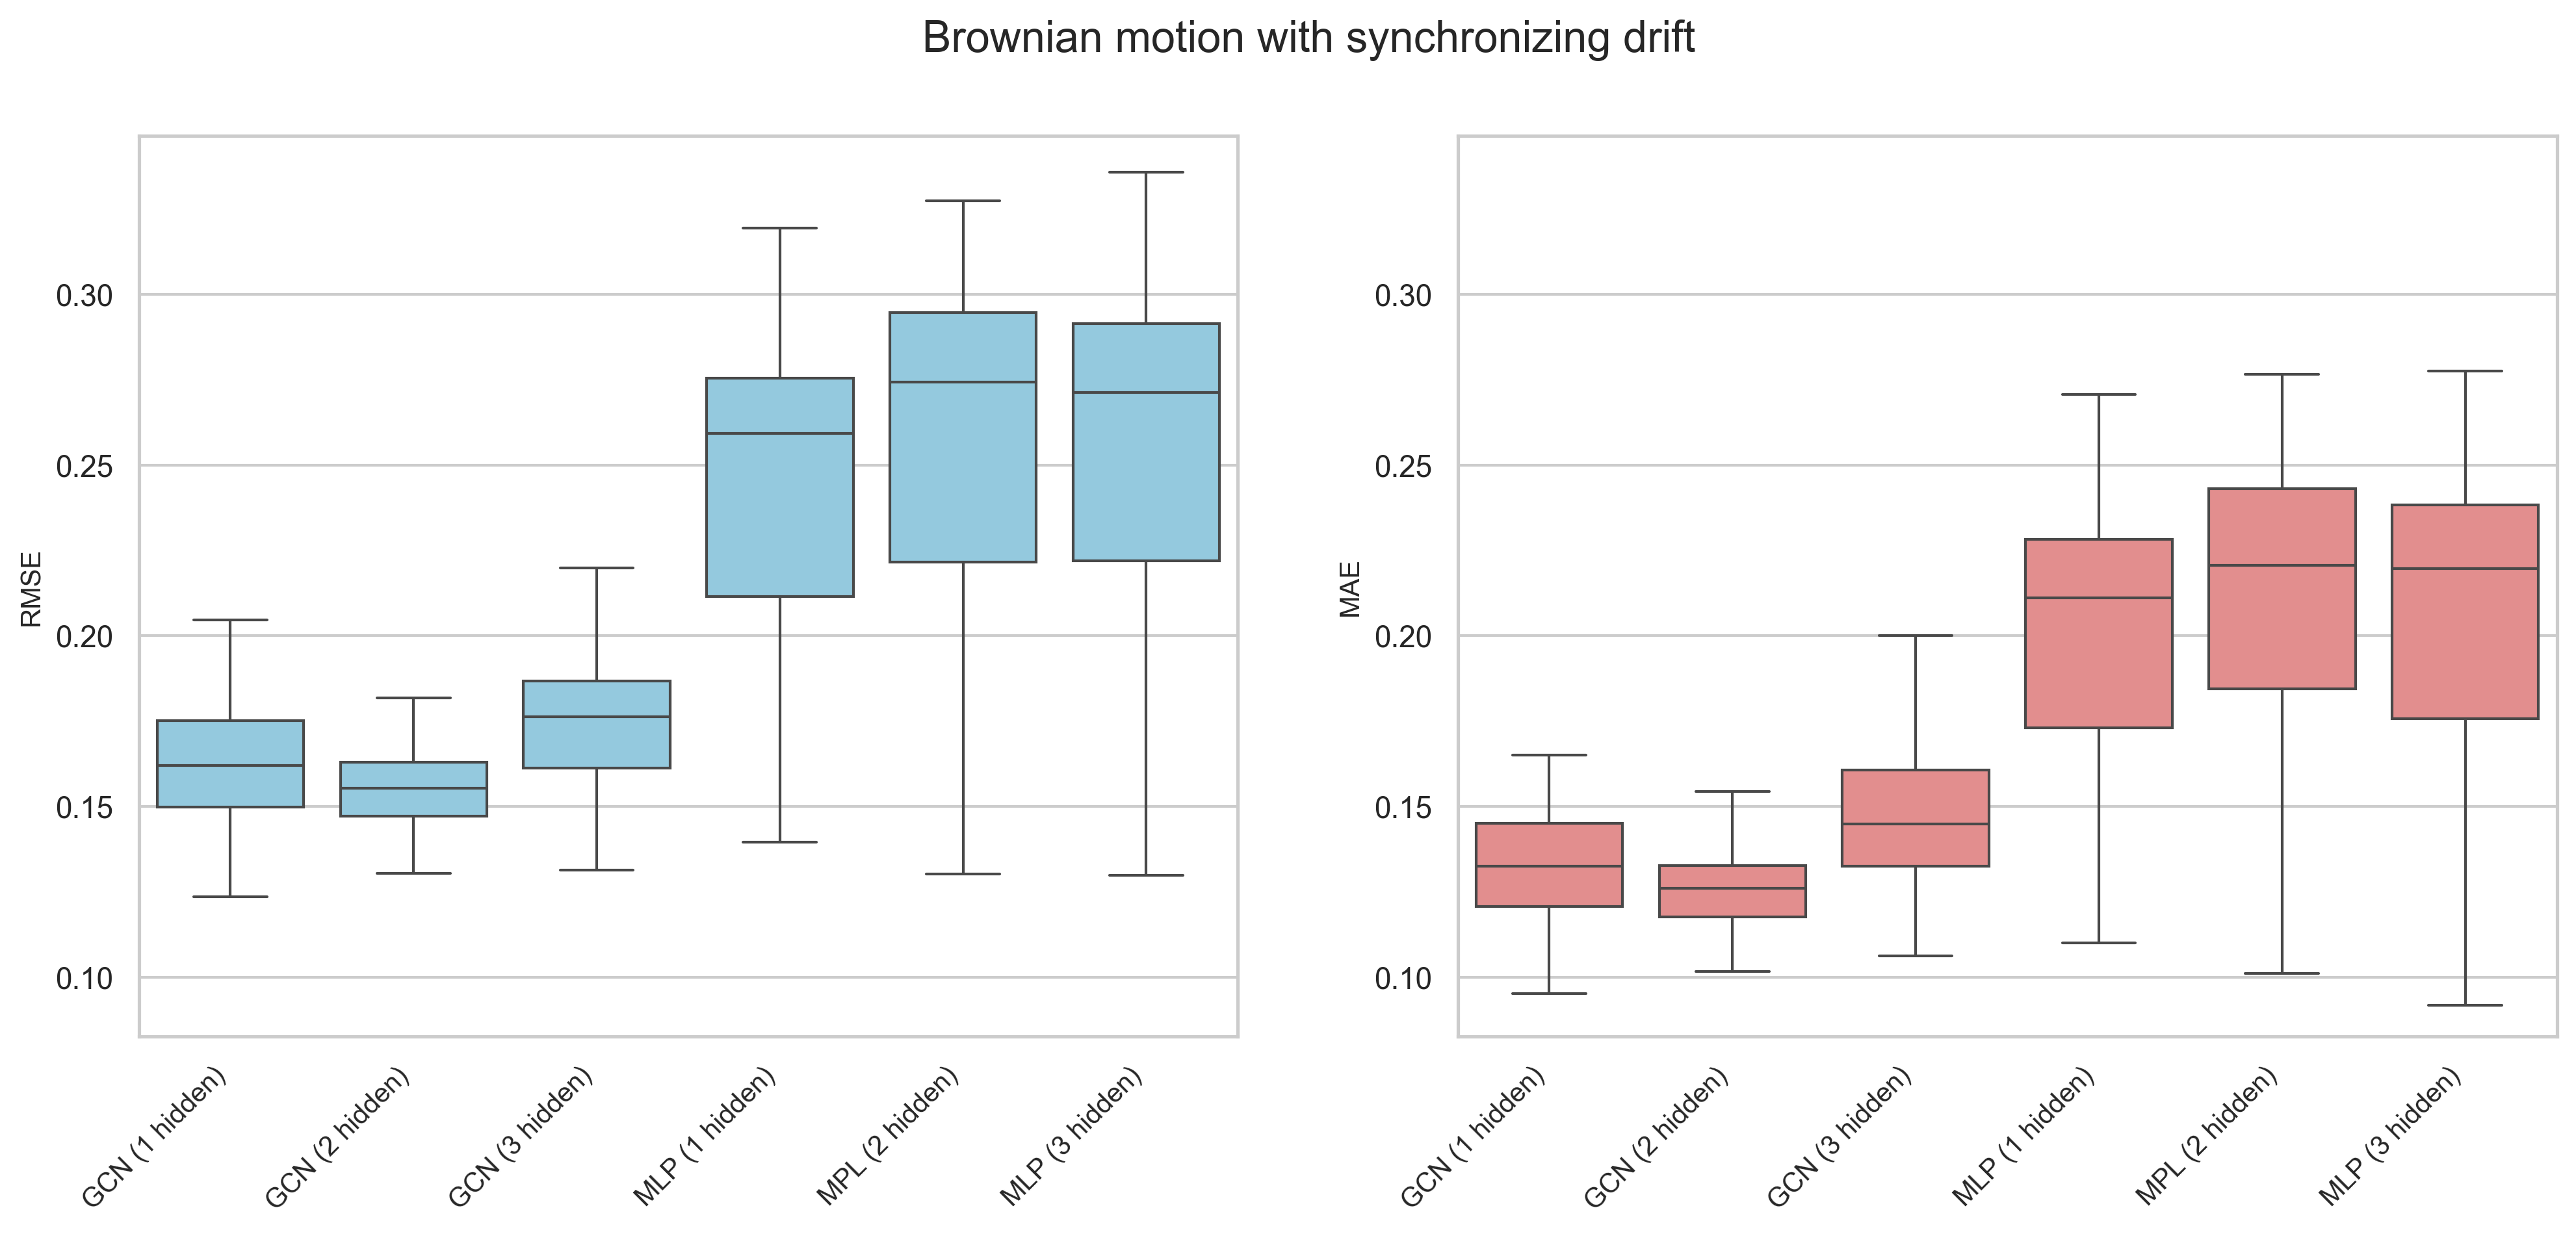

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model_names = ['GCN (1 hidden)','GCN (2 hidden)','GCN (3 hidden)','MLP (1 hidden)','MPL (2 hidden)','MLP (3 hidden)']

RMSE = np.array(rmse_models)
MAE = np.array(mae_models)

box_mse = np.reshape(RMSE, (-1, num_splits * num_runs * num_trials))
box_mae = np.reshape(MAE, (-1, num_splits * num_runs * num_trials))

# Set the seaborn theme
sns.set_theme(style="whitegrid")

# Create subplots with 1 row and 2 columns
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# Plot RMSE
sns.boxplot(data=[box_mse[i] for i in range(len(model_names))], ax=axis1, showfliers=False, color='skyblue')
axis1.set_ylabel('RMSE', fontsize=10)  # Set the font size for the y-axis label

# Plot MAE
sns.boxplot(data=[box_mae[i] for i in range(len(model_names))], ax=axis2, showfliers=False, color='lightcoral')
axis2.set_ylabel('MAE', fontsize=10)  # Set the font size for the y-axis label

# Set the same y-axis scale for both plots
y_min = min(axis1.get_ylim()[0], axis2.get_ylim()[0])
y_max = max(axis1.get_ylim()[1], axis2.get_ylim()[1])
axis1.set_ylim(y_min, y_max)
axis2.set_ylim(y_min, y_max)

axis1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)  # Set the font size for the x-axis labels and rotate them
axis2.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)  # Set the font size for the x-axis labels and rotate them

fig.suptitle('Brownian motion with synchronizing drift', fontsize=16)  # Set the title for the entire figure
plt.show()

### Graph Recurrent Convolutional Neutral Networks

In [ ]:
import torch
import torch.nn as nn
import signatory
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GConvGRURegression,GConvLSTMRegression
from pygsig.graph import StaticGraphTemporalSignal, split_nodes
from pygsig.signature import SignatureFeatures

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_splits = 4
num_runs = len(seq_dataset)
num_trials = 1
num_epochs = 100
num_nodes = seq_dataset[0].num_nodes
dim = seq_dataset[0].num_node_features
num_snapshots = seq_dataset[0].snapshot_count

learning_rate = 1e-3
lasso = 0
num_hidden = 8

print_during_training = False

# initialize models
models = []
models += [GConvGRURegression(num_channels=[dim, num_hidden, 1],K=2)]

mse_models = []
mae_models = []

for model in models:
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso)
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs,num_snapshots])
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs,num_snapshots])
    mse = np.zeros([num_splits, num_runs, num_trials])
    mae = np.zeros([num_splits, num_runs, num_trials])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,seed=31)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, seq in enumerate(seq_dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        for t,snapshot in enumerate(seq):
                            # train
                            model.train()
                            optimizer.zero_grad()
                            out = model(snapshot.x, snapshot.edge_index)
                            train_loss = criterion(out[train_mask], snapshot.y[train_mask])
                            train_loss.backward()
                            optimizer.step()
                            # evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], snapshot.y[eval_mask])
                                train_losses[split, run, trial, epoch,t] = train_loss.item()
                                eval_losses[split, run, trial, epoch,t] = eval_loss.item()
                            if epoch % 10 == 0 and print_during_training:
                                print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Test MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)

                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(snapshot.x, snapshot.edge_index)
                        mse[split, run, trial] = mean_squared_error(snapshot.y[test_mask], out[test_mask])
                        mae[split, run, trial] = mean_absolute_error(snapshot.y[test_mask], out[test_mask])

    print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f} ')  
    mse_models.append(mse)
    mae_models.append(mae)


    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2,-1))
    avg_eval_losses = np.mean(eval_losses, axis=(0,1,2,-1))
    std_train_losses = np.std(train_losses, axis=(0,1,2,-1))
    std_eval_losses = np.std(eval_losses, axis=(0,1,2,-1))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses,  label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1,color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Loss Curves for {model._get_name()}')
    plt.legend()
    plt.show()